In [1]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from examples.models.initializer import initialize_torchvision_model

import suitability.filter.tests as ftests
from suitability.datasets.wilds import get_wilds_dataset
from suitability.filter.margin_tuning import tune_margin
from suitability.filter.sample_signals import (
    ConfidenceSignal,
    CorrectnessSignal,
    DecisionBoundarySignal,
    LogitSignal,
    TrainingDynamicsSignal,
)

# importlib.reload(ftests)

random.seed(32)
np.random.seed(32)

In [2]:
def remove_prefix_from_state_dict(state_dict, prefix="model."):
    """
    Remove the prefix from the keys in state_dict if it exists.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix) :]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

## Region-based test data split
### Calculate Signals

In [69]:
root_dir = "/mfsnic/u/apouget/data/"
dataset_name = "fmow"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = initialize_torchvision_model("densenet121", d_out=62, pretrained=True)
state_dict = remove_prefix_from_state_dict(
    torch.load(
        f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth"
    )["algorithm"]
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Determine data splits
REGIONS = ["Asia", "Europe", "Africa", "Americas", "Oceania"]

# Construct suitability filter
confidences = {}
logits = {}
correctness = {}

for region in REGIONS:
    data = get_wilds_dataset(
        dataset_name,
        root_dir,
        "test",
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pre_filter={"region": region},
    )

    signal = ConfidenceSignal(model, device)
    conf = signal.evaluate(data)
    confidences[region] = conf

    signal = CorrectnessSignal(model, device)
    corr = signal.evaluate(data)
    correctness[region] = corr

    signal = LogitSignal(model, device)
    logit = signal.evaluate(data)
    logits[region] = logit

    print(f"Region {region}: {np.mean(correctness[region]) * 100:.2f}% correct")

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Region Asia: 55.35% correct
Region Europe: 56.16% correct
Region Africa: 32.78% correct
Region Americas: 56.72% correct
Region Oceania: 59.46% correct


### Statistical Testing & Margin Tuning

In [61]:
eval_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Europe"},
)
tuning_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4
)
model.load_state_dict(state_dict)
model.to(device)
test_fn = ftests.non_inferiority_ttest

signal = ConfidenceSignal(model, device)
conf = signal.evaluate(tuning_data)
bm_conf = signal.evaluate(eval_data)
s2 = CorrectnessSignal(model, device)
corr = s2.evaluate(tuning_data)
conf_margin = tune_margin(
    corr,
    conf,
    bm_conf,
    test_fn,
    0.58,
    delta_x=0.1,
    initial_m=0.07,
    delta_m=0.001,
    accuracy_threshold=0.05,
    max_iters=100,
    subsample_size=1000,
)
print(f"Confidence margin: {conf_margin}")

signal = LogitSignal(model, device)
log = signal.evaluate(tuning_data)
bm_log = signal.evaluate(eval_data)
s2 = CorrectnessSignal(model, device)
corr = s2.evaluate(tuning_data)
log_margin = tune_margin(
    corr,
    log,
    bm_log,
    test_fn,
    0.58,
    delta_x=0.1,
    initial_m=0.19,
    delta_m=0.001,
    accuracy_threshold=0.05,
    max_iters=100,
    subsample_size=1000,
)
print(f"Logit margin: {log_margin}")

Convergence sanity check: Margin has been increased 11 times and decreased 62 times out of 100 iterations.
Confidence margin: 0.01899999999999996
Convergence sanity check: Margin has been increased 8 times and decreased 45 times out of 100 iterations.
Logit margin: 0.15299999999999997


In [71]:
test_fn = ftests.non_inferiority_ttest

for region in REGIONS:
    conf = test_fn(bm_conf, confidences[region], margin=conf_margin)
    log = test_fn(bm_log, logits[region], margin=log_margin)
    print(f"EU vs {region} confidences:", conf)
    print(f"EU vs {region} logits:", log)
    hmp = 1 / (1 / conf["p_value"] + 1 / log["p_value"])
    print(
        f"EU vs {region} (with accuracy {np.mean(correctness[region]) * 100:.2f}) overall: {hmp:.2e}",
        "--> SUITABLE!" if hmp < 0.05 else "--> NOT SUITABLE!",
    )

EU vs Asia confidences: {'t_statistic': 3.7801734386000496, 'p_value': 0.9999211916311214, 'reject_null': False}
EU vs Asia logits: {'t_statistic': -5.780037199879678, 'p_value': 3.836398656972573e-09, 'reject_null': True}
EU vs Asia (with accuracy 55.35) overall: 3.84e-09 --> SUITABLE!
EU vs Europe confidences: {'t_statistic': 2.9900213144951864, 'p_value': 0.9986024304716152, 'reject_null': False}
EU vs Europe logits: {'t_statistic': -8.660727529329906, 'p_value': 2.6254388248419595e-18, 'reject_null': True}
EU vs Europe (with accuracy 56.16) overall: 2.63e-18 --> SUITABLE!
EU vs Africa confidences: {'t_statistic': 12.995355492761613, 'p_value': 1.0, 'reject_null': False}
EU vs Africa logits: {'t_statistic': 10.090177725628994, 'p_value': 1.0, 'reject_null': False}
EU vs Africa (with accuracy 32.78) overall: 5.00e-01 --> NOT SUITABLE!
EU vs Americas confidences: {'t_statistic': 0.9412847286942814, 'p_value': 0.8267132983487635, 'reject_null': False}
EU vs Americas logits: {'t_statist

In [17]:
for region in REGIONS:
    print(f"{region}, {len(confidences[region])}")

Asia, 4963
Europe, 5858
Africa, 2593
Americas, 8024
Oceania, 666


### Plot Results

In [72]:
# Function to split data into k approximately equal folds
def create_folds(data, k):
    # np.array_split ensures nearly equal splits
    return np.array_split(data, k)


# Function to perform t-tests and calculate accuracy using k-fold approach
def run_tests_for_samples(
    signals, bm_signal, correctness, sample_sizes, test_fn, increase_good=True, margin=0
):
    results = []
    for sample_size in sample_sizes:
        for region in ["Asia", "Europe", "Africa", "Americas"]:
            indices = np.arange(len(signals[region]))
            np.random.shuffle(indices)
            signals[region] = signals[region][indices]
            correctness[region] = correctness[region][indices]
            # Determine the number of folds (k) based on the length of the signal array
            num_folds = len(signals[region]) // sample_size
            if num_folds == 0:  # In case the sample size is larger than the region data
                num_folds = 1  # Ensure there's at least one fold

            # Create folds for signals and correctness for the current region
            signal_folds = create_folds(signals[region], num_folds)
            correctness_folds = create_folds(correctness[region], num_folds)

            # Loop through each fold for trials
            for fold in range(num_folds):
                row = {"sample_size": sample_size, "fold": fold}

                # Sample from the confidence scores and correctness of the region
                sampled_signals = signal_folds[fold]
                sampled_correctness = correctness_folds[fold]

                # Perform t-test between EU and the sampled region
                res = test_fn(
                    np.array(bm_signal),
                    np.array(sampled_signals),
                    increase_good=increase_good,
                    margin=margin,
                )
                row[f"p-value {region}"] = res["p_value"]
                row[f"t-statistic {region}"] = res["t_statistic"]

                # Calculate accuracy of the sampled region
                sampled_accuracy = (
                    np.mean(sampled_correctness) * 100
                )  # Accuracy in percentage
                row[f"accuracy {region}"] = sampled_accuracy

                results.append(row)

    return pd.DataFrame(results)


# Sample sizes to test
sample_sizes = [
    5,
    10,
    50,
    100,
    150,
    200,
    300,
    400,
    500,
    600,
    700,
    800,
    1000,
    1200,
    1500,
    1600,
    2000,
]

# Run tests across multiple trials for confidence, decision boundaries, and training dynamics
df_conf = run_tests_for_samples(
    confidences, bm_conf, correctness, sample_sizes, test_fn, margin=conf_margin
)
df_log = run_tests_for_samples(
    logits, bm_log, correctness, sample_sizes, test_fn, margin=log_margin
)

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


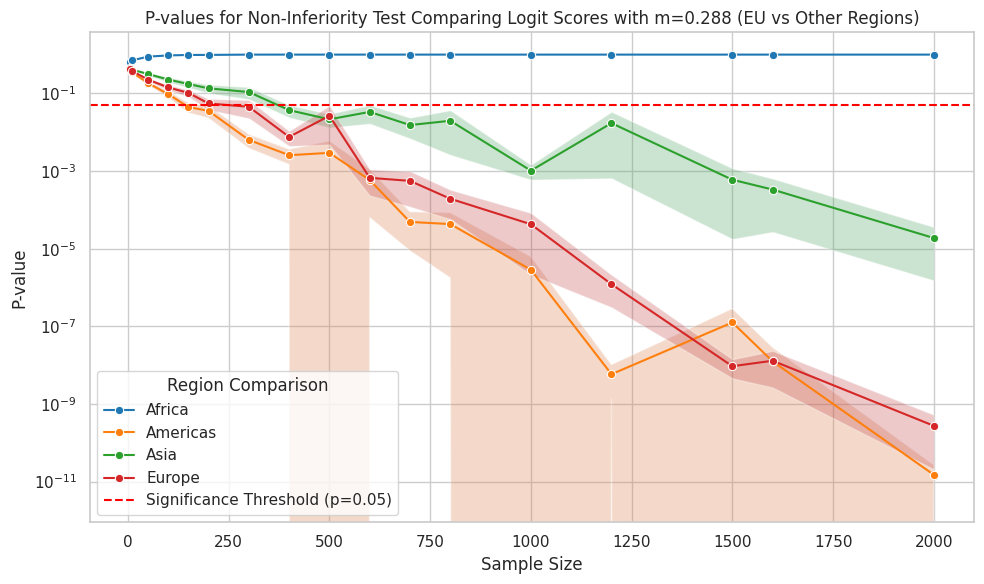

In [73]:
# Select one of the DataFrames to plot
df = df_log  # or df_conf
name = f"Logit Scores with m={log_margin:.3f}"

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Melt the DataFrame for easier plotting with seaborn
df_melted = df.melt(
    id_vars=["sample_size", "fold"],
    value_vars=["p-value Asia", "p-value Europe", "p-value Africa", "p-value Americas"],
    var_name="Comparison",
    value_name="p-value",
)

# Rename columns for better readability in the plot
df_melted["Comparison"] = df_melted["Comparison"].replace(
    {
        "p-value Asia": "Asia",
        "p-value Europe": "Europe",
        "p-value Africa": "Africa",
        "p-value Americas": "Americas",
    }
)

# Group by sample size and comparison, then calculate mean and 95% CI, averaging over the folds
df_summary = (
    df_melted.groupby(["sample_size", "Comparison"])
    .agg(
        p_value_mean=("p-value", "mean"),  # Mean of p-values across folds
        p_value_std=("p-value", "std"),  # Standard deviation of p-values across folds
        n=("p-value", "size"),  # Number of folds for each sample_size and comparison
    )
    .reset_index()
)

# Calculate the 95% confidence intervals
df_summary["ci_upper"] = df_summary["p_value_mean"] + 1.96 * (
    df_summary["p_value_std"] / np.sqrt(df_summary["n"])
)
df_summary["ci_lower"] = df_summary["p_value_mean"] - 1.96 * (
    df_summary["p_value_std"] / np.sqrt(df_summary["n"])
)

# Create the plot with means and confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_summary,
    x="sample_size",
    y="p_value_mean",
    hue="Comparison",
    marker="o",
    palette="tab10",
)

# Plot the confidence interval as a shaded region
for comparison in df_summary["Comparison"].unique():
    subset = df_summary[df_summary["Comparison"] == comparison]
    plt.fill_between(
        subset["sample_size"], subset["ci_lower"], subset["ci_upper"], alpha=0.3
    )

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(
    y=0.05, color="red", linestyle="--", label="Significance Threshold (p=0.05)"
)

# Customize the plot
plt.title(f"P-values for Non-Inferiority Test Comparing {name} (EU vs Other Regions)")
plt.xlabel("Sample Size")
plt.ylabel("P-value")
plt.yscale("log")  # Optional: Use logarithmic scale for p-values
plt.legend(title="Region Comparison")
plt.tight_layout()

# Show the plot
plt.show()


## Accuracy-based test data split
### Calculate Signals

In [3]:
root_dir = "/mfsnic/u/apouget/data/"
dataset_name = "fmow"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = initialize_torchvision_model("densenet121", d_out=62, pretrained=True)
state_dict = remove_prefix_from_state_dict(
    torch.load(
        f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth"
    )["algorithm"]
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Construct suitability filter
data = get_wilds_dataset(
    dataset_name, root_dir, "test", batch_size=64, shuffle=False, num_workers=4
)

signal = ConfidenceSignal(model, device)
conf = signal.evaluate(data)

signal = CorrectnessSignal(model, device)
corr = signal.evaluate(data)

signal = LogitSignal(model, device)
logit = signal.evaluate(data)

print(f"Accuracy: {np.mean(corr) * 100:.2f}% correct")

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 53.55% correct


### Margin Tuning

In [13]:
# Europe val: 5268 images, ~60% accuracy
eval_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Europe"},
)
# Americas val: 3076 images, ~63% accuracy
tuning_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Americas"},
)
model.load_state_dict(state_dict)
model.to(device)

tune_conf_signal = ConfidenceSignal(model, device)
tune_conf = tune_conf_signal.evaluate(tuning_data)
bm_conf = tune_conf_signal.evaluate(eval_data)
tune_corr_signal = CorrectnessSignal(model, device)
tune_corr = tune_corr_signal.evaluate(tuning_data)
tune_log_signal = LogitSignal(model, device)
tune_log = tune_log_signal.evaluate(tuning_data)
bm_log = tune_log_signal.evaluate(eval_data)

def tune_margin_fmow(num_samples, target_accuracy):
    conf_margin = tune_margin(
        tune_corr,
        tune_conf,
        bm_conf,
        test_fn,
        target_accuracy,
        delta_x=0.1,
        initial_m=0.07,
        delta_m=0.001,
        accuracy_threshold=0.05,
        max_iters=100,
        subsample_size=num_samples,
    )
    log_margin = tune_margin(
        tune_corr,
        tune_log,
        bm_log,
        test_fn,
        target_accuracy,
        delta_x=0.1,
        initial_m=0.19,
        delta_m=0.001,
        accuracy_threshold=0.05,
        max_iters=100,
        subsample_size=num_samples,
    )

    return conf_margin, log_margin

### Split into groups of different accuracies

In [14]:
def evaluate_suitability_fmow(n_subsets, conf_margin, log_margin):
    # Number of subsets and target accuracies
    target_accuracies = np.linspace(0.3, 0.75, n_subsets)
    total_samples = len(corr)

    # Shuffle the data to randomize distribution
    indices = np.random.permutation(total_samples)
    shuffled_correctness = corr[indices]
    shuffled_logits = logit[indices]
    shuffled_confidences = conf[indices]

    # Create subsets with specific accuracies
    subsets_correctness = [None] * n_subsets
    subsets_logits = [None] * n_subsets
    subsets_confidences = [None] * n_subsets
    subsets_p_values_log = [None] * n_subsets
    subsets_t_statistics_log = [None] * n_subsets
    subsets_p_values_conf = [None] * n_subsets
    subsets_t_statistics_conf = [None] * n_subsets
    subsets_hmp = [None] * n_subsets
    accuracies = [None] * n_subsets
    start_idx = 0

    for i, target_accuracy in enumerate(target_accuracies):
        # Calculate the number of correct and incorrect samples needed for the subset
        subset_size = total_samples // n_subsets
        n_correct = int(subset_size * target_accuracy)
        n_incorrect = subset_size - n_correct

        # Find the correct/incorrect samples in the shuffled data
        correct_indices = np.where(shuffled_correctness[start_idx:] == 1)[0][:n_correct]
        incorrect_indices = np.where(shuffled_correctness[start_idx:] == 0)[0][:n_incorrect]

        # Get the final indices for the current subset
        subset_indices = np.concatenate((correct_indices, incorrect_indices)) + start_idx

        # Extract the subset from correctness and logits arrays
        subsets_correctness[i] = shuffled_correctness[subset_indices]
        subsets_logits[i] = shuffled_logits[subset_indices]
        subsets_confidences[i] = shuffled_confidences[subset_indices]

        # Move the start index forward
        start_idx += len(subset_indices)

        # Print the achieved accuracy
        # accuracy = np.mean(subsets_correctness[i])
        # subset_size = len(subset_indices)
        # print(
        #     f"Subset of size {subset_size} with target accuracy {target_accuracy:.2f}: Achieved accuracy = {accuracy:.2f}"
        # )

        c_test = test_fn(bm_conf, subsets_confidences[i], margin=conf_margin)
        l_test = test_fn(bm_log, subsets_logits[i], margin=log_margin)
        hmp = 1 / (1 / c_test["p_value"] + 1 / l_test["p_value"])
        subsets_p_values_conf[i] = c_test["p_value"]
        subsets_t_statistics_conf[i] = c_test["t_statistic"]
        subsets_p_values_log[i] = l_test["p_value"]
        subsets_t_statistics_log[i] = l_test["t_statistic"]
        subsets_hmp[i] = hmp
        accuracies[i] = np.mean(subsets_correctness[i])

    return subsets_p_values_conf, subsets_t_statistics_conf, subsets_p_values_log, subsets_t_statistics_log, subsets_hmp, accuracies


Convergence sanity check: Margin has been increased 6 times and decreased 54 times out of 100 iterations.
Convergence sanity check: Margin has been increased 1 times and decreased 24 times out of 100 iterations.
Subset size: 4421, conf_margin: 0.021999999999999964, log_margin: 0.16699999999999998
Convergence sanity check: Margin has been increased 6 times and decreased 52 times out of 100 iterations.
Convergence sanity check: Margin has been increased 4 times and decreased 23 times out of 100 iterations.
Subset size: 3158, conf_margin: 0.023999999999999966, log_margin: 0.17099999999999999
Convergence sanity check: Margin has been increased 8 times and decreased 53 times out of 100 iterations.
Convergence sanity check: Margin has been increased 8 times and decreased 21 times out of 100 iterations.
Subset size: 2210, conf_margin: 0.024999999999999967, log_margin: 0.177
Convergence sanity check: Margin has been increased 9 times and decreased 54 times out of 100 iterations.
Convergence sa

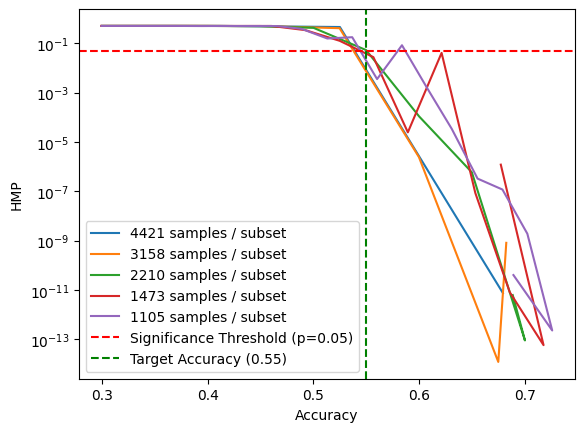

In [15]:
subset_cnt = [5, 7, 10, 15, 20]
target_accuracy = 0.55
test_fn = ftests.non_inferiority_ttest

for cnt in subset_cnt:
    conf_margin, log_margin = tune_margin_fmow(len(corr)//cnt, target_accuracy)
    subsets_p_values_conf, subsets_t_statistics_conf, subsets_p_values_log, subsets_t_statistics_log, subsets_hmp, accuracies = evaluate_suitability_fmow(cnt, conf_margin, log_margin)
    plt.plot(accuracies, subsets_hmp, label=f"{len(corr)//cnt} samples / subset")
    print(f"Subset size: {len(corr)//cnt}, conf_margin: {conf_margin}, log_margin: {log_margin}")

plt.xlabel("Accuracy")
plt.ylabel("HMP")
plt.yscale("log")
plt.axhline(
    y=0.05, color="red", linestyle="--", label="Significance Threshold (p=0.05)"
)
plt.axvline(
    x=target_accuracy, color="green", linestyle="--", label=f"Target Accuracy ({target_accuracy})"
)
plt.title("HMP vs Accuracy for Different Subset Sizes")
plt.legend()
plt.show()


Convergence sanity check: Margin has been increased 6 times and decreased 53 times out of 100 iterations.
Convergence sanity check: Margin has been increased 2 times and decreased 24 times out of 100 iterations.
Subset size: 4421, conf_margin: 0.022999999999999965, log_margin: 0.16799999999999998
Convergence sanity check: Margin has been increased 7 times and decreased 55 times out of 100 iterations.
Convergence sanity check: Margin has been increased 1 times and decreased 22 times out of 100 iterations.
Subset size: 3158, conf_margin: 0.021999999999999964, log_margin: 0.16899999999999998
Convergence sanity check: Margin has been increased 9 times and decreased 56 times out of 100 iterations.
Convergence sanity check: Margin has been increased 8 times and decreased 24 times out of 100 iterations.
Subset size: 2210, conf_margin: 0.022999999999999965, log_margin: 0.174
Convergence sanity check: Margin has been increased 11 times and decreased 56 times out of 100 iterations.
Convergence s

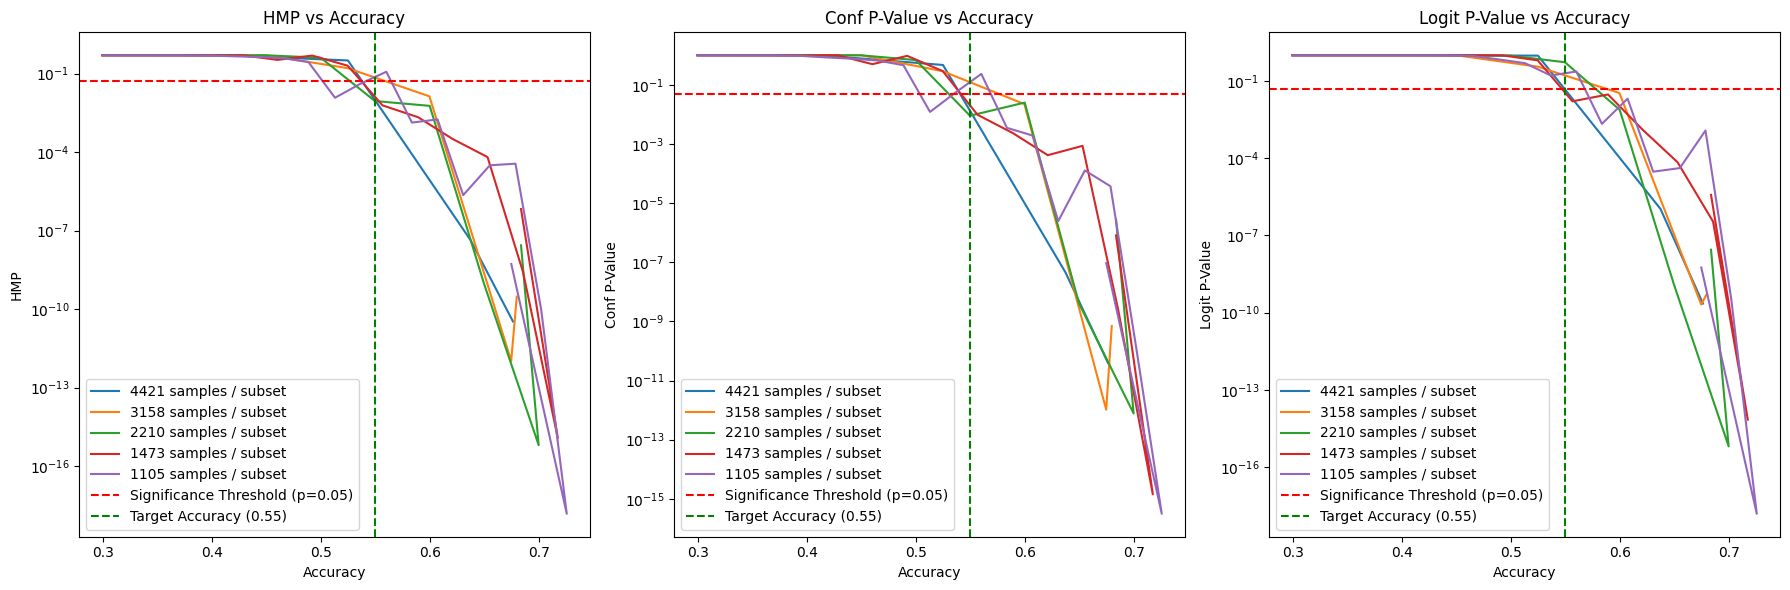

In [16]:
# Define the number of subsets and target accuracy
subset_cnt = [5, 7, 10, 15, 20]
target_accuracy = 0.55
test_fn = ftests.non_inferiority_ttest

# Prepare a 1x3 grid for subplots (HMP, Conf P-Value, Logit P-Value)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax_hmp, ax_conf_pval, ax_log_pval = axes

# Iterate through subset counts and evaluate margins and subsets
for cnt in subset_cnt:
    # Calculate margins for the current subset count
    conf_margin, log_margin = tune_margin_fmow(len(corr)//cnt, target_accuracy)
    
    # Evaluate the suitability and obtain the required statistics
    subsets_p_values_conf, subsets_t_statistics_conf, subsets_p_values_log, subsets_t_statistics_log, subsets_hmp, accuracies = evaluate_suitability_fmow(cnt, conf_margin, log_margin)
    
    # Plot HMP vs Accuracy
    ax_hmp.plot(accuracies, subsets_hmp, label=f"{len(corr)//cnt} samples / subset")
    
    # Plot Conf P-Value vs Accuracy
    ax_conf_pval.plot(accuracies, subsets_p_values_conf, label=f"{len(corr)//cnt} samples / subset")
    
    # Plot Logit P-Value vs Accuracy
    ax_log_pval.plot(accuracies, subsets_p_values_log, label=f"{len(corr)//cnt} samples / subset")
    
    # Print subset size, margins for debugging/logging
    print(f"Subset size: {len(corr)//cnt}, conf_margin: {conf_margin}, log_margin: {log_margin}")

# Customize the HMP plot
ax_hmp.set_xlabel("Accuracy")
ax_hmp.set_ylabel("HMP")
ax_hmp.set_yscale("log")
ax_hmp.axhline(y=0.05, color="red", linestyle="--", label="Significance Threshold (p=0.05)")
ax_hmp.axvline(x=target_accuracy, color="green", linestyle="--", label=f"Target Accuracy ({target_accuracy})")
ax_hmp.set_title("HMP vs Accuracy")
ax_hmp.legend()

# Customize the Conf P-Value plot
ax_conf_pval.set_xlabel("Accuracy")
ax_conf_pval.set_ylabel("Conf P-Value")
ax_conf_pval.set_yscale("log")
ax_conf_pval.axhline(y=0.05, color="red", linestyle="--", label="Significance Threshold (p=0.05)")
ax_conf_pval.axvline(x=target_accuracy, color="green", linestyle="--", label=f"Target Accuracy ({target_accuracy})")
ax_conf_pval.set_title("Conf P-Value vs Accuracy")
ax_conf_pval.legend()

# Customize the Logit P-Value plot
ax_log_pval.set_xlabel("Accuracy")
ax_log_pval.set_ylabel("Logit P-Value")
ax_log_pval.set_yscale("log")
ax_log_pval.axhline(y=0.05, color="red", linestyle="--", label="Significance Threshold (p=0.05)")
ax_log_pval.axvline(x=target_accuracy, color="green", linestyle="--", label=f"Target Accuracy ({target_accuracy})")
ax_log_pval.set_title("Logit P-Value vs Accuracy")
ax_log_pval.legend()

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()


Convergence sanity check: Margin has been increased 6 times and decreased 52 times out of 100 iterations.
Convergence sanity check: Margin has been increased 0 times and decreased 20 times out of 100 iterations.
Subset size: 4421, conf_margin: 0.023999999999999966, log_margin: 0.16999999999999998
Convergence sanity check: Margin has been increased 8 times and decreased 53 times out of 100 iterations.
Convergence sanity check: Margin has been increased 5 times and decreased 20 times out of 100 iterations.
Subset size: 3158, conf_margin: 0.024999999999999967, log_margin: 0.175
Convergence sanity check: Margin has been increased 9 times and decreased 55 times out of 100 iterations.
Convergence sanity check: Margin has been increased 5 times and decreased 21 times out of 100 iterations.
Subset size: 2210, conf_margin: 0.023999999999999966, log_margin: 0.174
Convergence sanity check: Margin has been increased 11 times and decreased 55 times out of 100 iterations.
Convergence sanity check: M

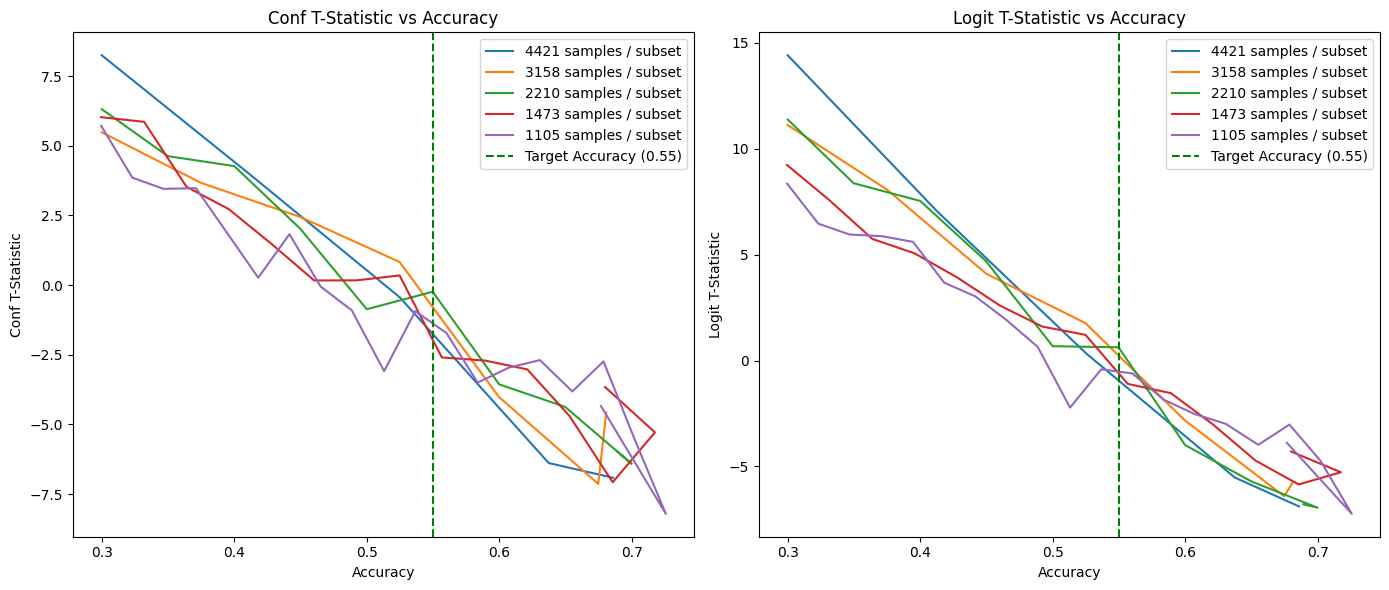

In [17]:
import matplotlib.pyplot as plt

# Define the number of subsets and target accuracy
subset_cnt = [5, 7, 10, 15, 20]
target_accuracy = 0.55
test_fn = ftests.non_inferiority_ttest

# Prepare a 1x2 grid for subplots (Conf T-Statistic, Logit T-Statistic)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax_conf_tstat, ax_log_tstat = axes

# Iterate through subset counts and evaluate margins and subsets
for cnt in subset_cnt:
    # Calculate margins for the current subset count
    conf_margin, log_margin = tune_margin_fmow(len(corr)//cnt, target_accuracy)
    
    # Evaluate the suitability and obtain the required statistics
    subsets_p_values_conf, subsets_t_statistics_conf, subsets_p_values_log, subsets_t_statistics_log, subsets_hmp, accuracies = evaluate_suitability_fmow(cnt, conf_margin, log_margin)
    
    # Plot Conf T-Statistic vs Accuracy
    ax_conf_tstat.plot(accuracies, subsets_t_statistics_conf, label=f"{len(corr)//cnt} samples / subset")
    
    # Plot Logit T-Statistic vs Accuracy
    ax_log_tstat.plot(accuracies, subsets_t_statistics_log, label=f"{len(corr)//cnt} samples / subset")
    
    # Print subset size, margins for debugging/logging
    print(f"Subset size: {len(corr)//cnt}, conf_margin: {conf_margin}, log_margin: {log_margin}")

# Customize the Conf T-Statistic plot
ax_conf_tstat.set_xlabel("Accuracy")
ax_conf_tstat.set_ylabel("Conf T-Statistic")
ax_conf_tstat.axvline(x=target_accuracy, color="green", linestyle="--", label=f"Target Accuracy ({target_accuracy})")
ax_conf_tstat.set_title("Conf T-Statistic vs Accuracy")
ax_conf_tstat.legend()

# Customize the Logit T-Statistic plot
ax_log_tstat.set_xlabel("Accuracy")
ax_log_tstat.set_ylabel("Logit T-Statistic")
ax_log_tstat.axvline(x=target_accuracy, color="green", linestyle="--", label=f"Target Accuracy ({target_accuracy})")
ax_log_tstat.set_title("Logit T-Statistic vs Accuracy")
ax_log_tstat.legend()

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()
